# Курс по машинному обучению,   ВМК МГУ
## Деревья решений

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **Также в этом ноутбук есть задание на ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза "Вывод"/"Ответ на вопрос" итд, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

__В этом задании вы..:__

- Посмотрите глазами, как же работают деревья решений
- Релизуете различные меры качества разбиения в вершине 
- Посмотрите на разные методы ансамблирования деревьев решений
- Посмотрите на поведение качества ансамбля деревьев в зависимости от числа деревьев
- Изучите, как получить из обученного дерева важность признаков
- Порешаете интересную физическую задачку :)

-------------------------------

Привет, ребятушки!

Сегодня мы с вами посмотрим на такую вещь, как деревья решений. Мы попытаемся понять принцип их работы, пощупать, исследовать влияние параметров и, самое главное, узнаем, какое свойство случайных лесов оказало сильное влияние на машинное обучение.

Хочу обратить внимание, что в этом задании мы будем работать с регрессорами, однако все сделанные нами выводы верны также и для задач классификации.

**Внимание! При решении задач разрешается использовать ``n_jobs`` для ускорения обучения.**

**Внимание! Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

Для вычисления MAE можно использовать встроенную функцию sklearn.metrics.mean_absolute_error.

Импортируем необходимые библиотеки:

In [24]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR

import matplotlib.pyplot as plt

#####
# если вы не различаете предлагаемые цвета, то Вы можете раскомментить строку ниже
# для применения специальной цветовой палитры или аналогичных
# plt.style.use('tableau-colorblind10')
#####

import numpy as np

import time
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Задание для проверяющей системы
## Задание 0 (unit-тесты, 5 баллов)

Как Вы знаете из лекций, решающие деревья на каждом шаге разбивают множество объектов на два подмножества, выбирая такой критерий, по которому разбиение наиболее оптимальное. В качестве меры качества таких разбиений могут выступать три меры: Gini, Entropy и Classification Error. Вам нужно реализовать все три меры качества и загрузить их реализацию в тестирующую систему cv-gml.ru, в задание `Деревья решений (unit-tests)`.

Подробнее об этом задании вы можете прочитать в соответствующем .pdf файле.

## Как же работают деревья решений

На лекции вам рассказывали, что деревья решений несколько раз дробят выборки, используя какие-то значения
признаков, и таким образом строят цепочки условий для принятия решения. Давайте убедимся в этом лично.

Загрузим датасет со стоимостью недвижимости в Бостоне, который нам понадобится для первых заданий:

In [25]:
def get_boston_dataset():
    """Return the splits of the Boston dataset for training and testing"""
    X, y = load_boston(return_X_y=True)
    return train_test_split(X, y, random_state=42)

X_train, X_test, y_train, y_test = get_boston_dataset()

### Задание 1 (кросс-проверка, 2 балла)
**Данные**: датасет со стоимостью недвижимости в Бостоне  
**Цели**: В данном задании следует выполнить следующие пункты:

1. Обучить ``DecisionTreeRegressor`` на обучающей выборке, установив ``random_state=0``. Ограничить максимальную глубину дерева до 3, чтобы получившаяся визуализация не была слишком большой.
1. При помощи функции sklearn.tree.plot_tree визуализировать получившееся дерево. Можете передать load_boston().feature_names для улучшения визуализации. Для того чтобы визуализация выглядела лучше, можете воспользоваться аргументом fontsize, а также установить  ``plt.figure(figsize=(X,Y))``.
1. Взять любой объект из тестовой выборки. Предсказать его цену при помощи функции .predict обученного регрессора, а затем, воспользовавшись полученной визуализацией, опишите правила, по которым дерево сделало свой вывод. Опишите словами эти решения ниже.

In [26]:
decision_tree_regressor = DecisionTreeRegressor(max_depth=3, random_state=0)
tree = decision_tree_regressor.fit(X_train, y_train)

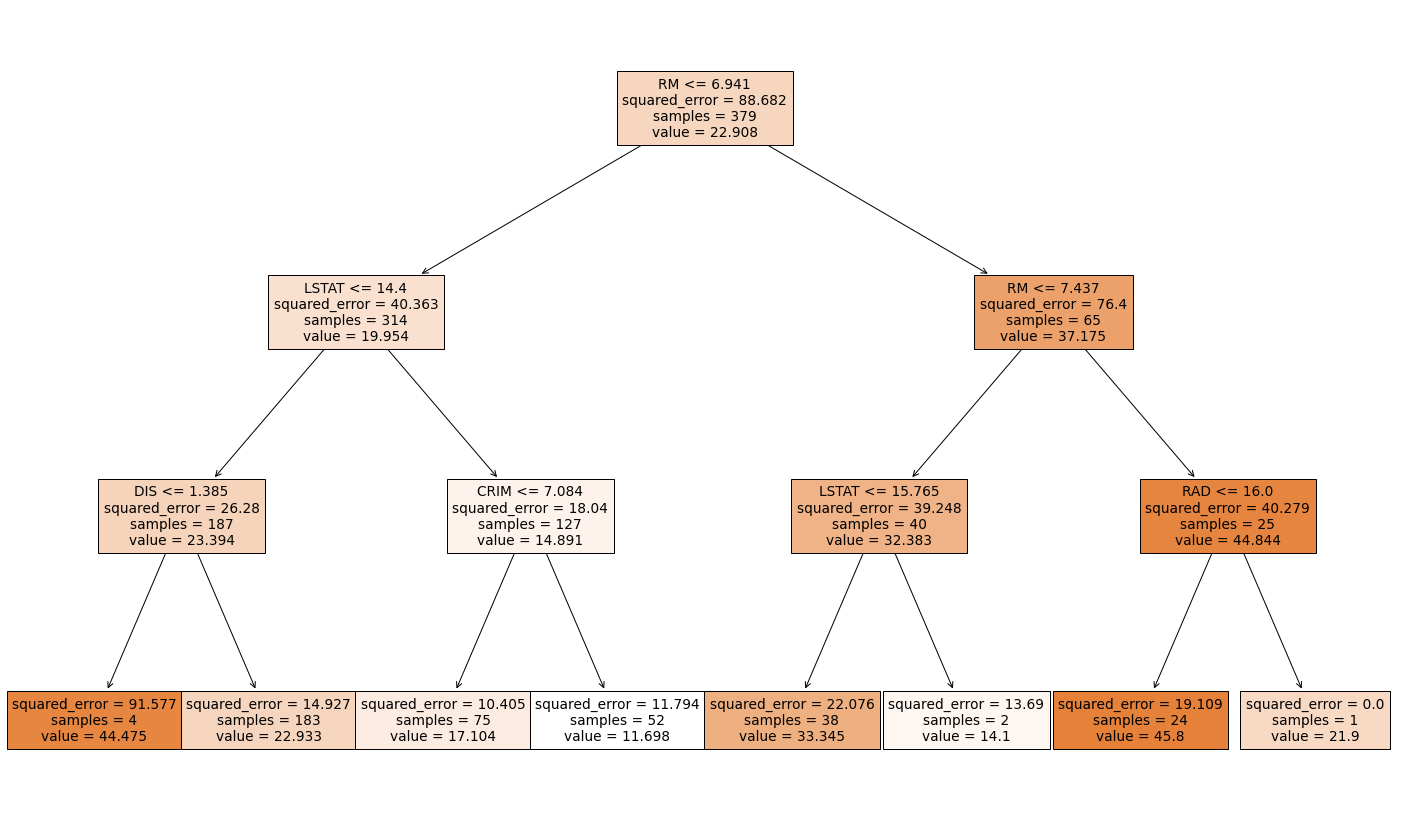

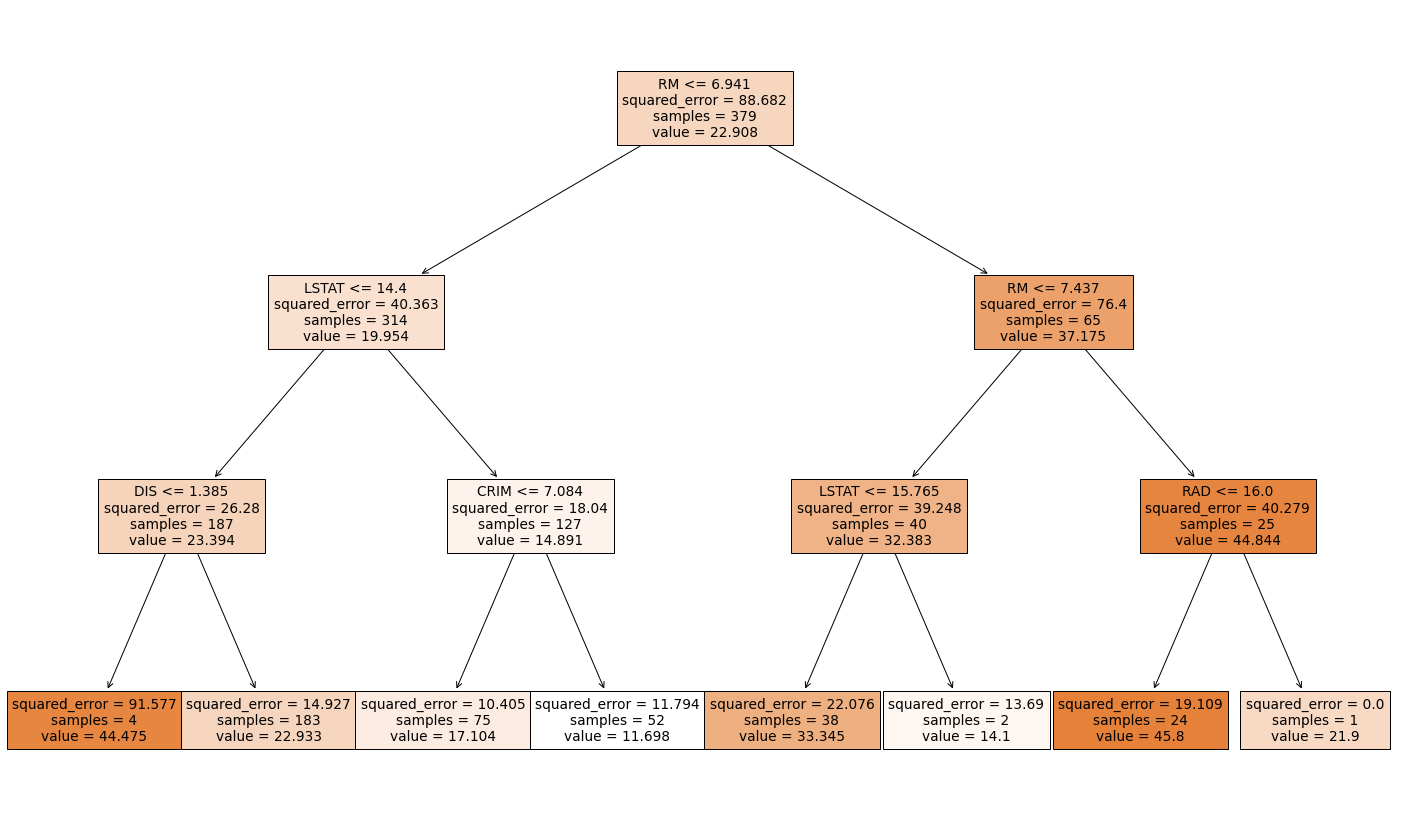

In [27]:
feature_names = load_boston().feature_names
fig = plt.figure(figsize=(25,15))
_ = plot_tree(tree, feature_names = feature_names, filled=True)

In [28]:
k = 5
Y_k_pred = tree.predict(X_test[k].reshape(-1,13))

In [29]:
list(X_test[k])

[0.10153,
 0.0,
 12.83,
 0.0,
 0.437,
 6.279,
 74.5,
 4.0522,
 5.0,
 398.0,
 18.7,
 373.66,
 11.97]

[0.10153,
 0.0,
 12.83,
 0.0,
 0.437,
 6.279,
 74.5,
 4.0522,
 5.0,
 398.0,
 18.7,
 373.66,
 11.97]

In [30]:
print('Predicted value is {:.3f}'.format(float(Y_k_pred)))

Predicted value is 22.933
Predicted value is 22.933


In [31]:
d = {feature_names[i]: X_test[k][i] for i in range(len(feature_names))}
print('features:', d)

features: {'CRIM': 0.10153, 'ZN': 0.0, 'INDUS': 12.83, 'CHAS': 0.0, 'NOX': 0.437, 'RM': 6.279, 'AGE': 74.5, 'DIS': 4.0522, 'RAD': 5.0, 'TAX': 398.0, 'PTRATIO': 18.7, 'B': 373.66, 'LSTAT': 11.97}
features: {'CRIM': 0.10153, 'ZN': 0.0, 'INDUS': 12.83, 'CHAS': 0.0, 'NOX': 0.437, 'RM': 6.279, 'AGE': 74.5, 'DIS': 4.0522, 'RAD': 5.0, 'TAX': 398.0, 'PTRATIO': 18.7, 'B': 373.66, 'LSTAT': 11.97}


**Ответ на вопрос (о том как предсказывается значение на объекте):**
1) Предполагается, что целевое значение 22.908  
2) Далее проверяется значение RM : если оно меньше или равно 6.941 (для этого объекта 6.279), то предполагается, что целевое значение 19.954  
3) Далее проверяется значение LSTAT: если оно меньше или равно 14.4 (для этого объекта 11.97), то предполагается, что целевое значение 23.394  
4) Далее проверяется значение DIS: если оно больше 1.385 (для этого объекта 4.0522), то предполагается, что целевое значение 22.933

Мы смогли убедиться, что дерево решений действительно строит систему правил, по которым предсказывает цену квартиры. Также мы можем убедиться, что множество возможных предсказаний регрессора сильно ограничено: все они перечислены в листовых вершинах графа. Но в чем же тогда сила деревьев решений, брат? Давайте разбираться дальше.

## Ансамбли решений

Теорема Кондорсе о присяжных (ознакомиться можно [здесь](https://neerc.ifmo.ru/wiki/index.php?title=%D0%92%D0%B8%D0%B4%D1%8B_%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B9#.D0.A2.D0.B5.D0.BE.D1.80.D0.B5.D0.BC.D0.B0_.D0.9A.D0.BE.D0.BD.D0.B4.D0.BE.D1.80.D1.81.D0.B5_.D0.BE_.D0.BF.D1.80.D0.B8.D1.81.D1.8F.D0.B6.D0.BD.D1.8B.D1.85)), переведённая на язык машинного обучения, гласит, что если у нас имеется некоторое количество различных методов, каждый из которых предсказывает величину лучше, чем случайно, то голосование таких методов работает лучше, чем любой из этих методов по отдельности. Давайте попробуем на простом примере проверить эту теорему.

### Задание 2.1 (кросс-проверка, 2 балла)
**Данные**: датасет со стоимостью недвижимости в Бостоне  
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить 3 дерева решений, для каждого при инициализации установить `random_state` равный 1, 2 и 3. В этот раз ограничивать глубину деревьев не нужно.
1. Получить предсказание для тестовой выборки от каждого регрессора, а также получить ``усреднённое`` предсказание.
1. Посчитать MAE для каждого из деревьев, полученных в первом пункте, а также для усреднённых предсказаний. Сделать вывод о том, стало лучше или нет.

In [32]:
regressor_1 = DecisionTreeRegressor(random_state=1)
tree_1 = regressor_1.fit(X_train, y_train)

regressor_2 = DecisionTreeRegressor(random_state=2)
tree_2 = regressor_2.fit(X_train, y_train)

regressor_3 = DecisionTreeRegressor(random_state=3)
tree_3 = regressor_3.fit(X_train, y_train)

y_pred_1 = tree_1.predict(X_test)
y_pred_2 = tree_2.predict(X_test)
y_pred_3 = tree_3.predict(X_test)

print('1st tree MAE:', mean_absolute_error(y_pred_1, y_test))
print('2nd tree MAE:', mean_absolute_error(y_pred_2, y_test))
print('3rd tree MAE:', mean_absolute_error(y_pred_3, y_test))
print('Average MAE:', mean_absolute_error((y_pred_1 + y_pred_2 + y_pred_3)/3, y_test))

1st tree MAE: 2.6259842519685033
2nd tree MAE: 2.705511811023621
3rd tree MAE: 2.61259842519685
Average MAE: 2.510498687664041
1st tree MAE: 2.6259842519685033
2nd tree MAE: 2.705511811023621
3rd tree MAE: 2.61259842519685
Average MAE: 2.510498687664041


***Ура, ошибка усредненного предсказания меньше, чем ошибки отдельных предсказаний!***

Надеюсь, мы смогли убедиться, что это действительно работает. Правда, улучшение достаточно маленькое. Для революции в машинном обучении этого еще недостаточно.

А что влияет на улучшение, которое мы получаем при использовании ансамбля методов? Соответствующая теорема дает достаточно простой ответ: различность методов и ведет к улучшению. Если у нас есть много методов, предсказания которых отличаются незначительно, то их усреднение практически ничего не изменит. Если же у нас есть множество достаточно разных методов, то и их усреднение будет отличаться от предсказаний каждого отдельного метода. Видимо, random_state было недостаточно. Как же нам еще сильнее увеличить различность методов? Ответ вы знаете: использовать случайные признаки и случайную выборку объектов. Это приводит нас к случайным лесам.

### Задание 2.2 (кросс-проверка, 1 балл)
**Данные**: датасет со стоимостью недвижимости в Бостоне  
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучить RandomForestRegressor. Для честности следует установить ``n_estimators=3``, то есть сделать число деревьев равным 3 (как мы сделали в предыдущем задании). Для однородности также поставьте ``random_state = 0``
1. Посчитать MAE полученных предсказаний. Сравнить их с результатами, полученными в предыдущем пункте. Сделайте вывод.

In [33]:
regressor = RandomForestRegressor(n_estimators=3, random_state = 0)
model = regressor.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Random forest MAE:', mean_absolute_error(y_pred, y_test))

Random forest MAE: 2.5585301837270342
Random forest MAE: 2.5585301837270342


**Вывод по результату**: Как и в предыдущем пункте, результаты лучше, чем результаты отдельных деревьев, но не лучше, чем у среднего предсказания.

Для революции и этого, кажется, маловато. Давайте продолжим исследовать случайные леса.

## Переобучение и зависимость предсказаний от числа деревьев

В прошлом задании мы вручную установили число деревьев в лесу равное трем, чтобы более честно сравниваться с нашим предыдущим ансамблем. Давайте изучим влияние этого параметра на результат предсказаний.

### Задание 3.1 (кросс-проверка, 5 баллов)
**Данные**: датасет со стоимостью недвижимости в Бостоне   
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучите 10 случайных лесов, установив random_state=42 и замерив время, потраченное на обучение. Для обучаемых лесов, используйте число деревьев (`n_estimators`) из `np.logspace(1, 4, num=10)` (округлите значения вниз до целых чисел). Таким образом мы получим оценку результата для лесов, построенных с различным числом деревьев.
1. Для всех 10 лесов посчитайте MAE на тренировочном и тестовом множествах.
1. Постройте график для отображения зависимости времени обучения от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите время, потраченное на обучение.
1. Постройте график для отображения зависимости значения MAE от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите одним цветом значение MAE на тренировочном множестве, другим цветом MAE на тестовом множестве.
1. Проанализируйте результаты и графики, сделайте выводы про время обучения при различном числе деревьев и про качество результатов (в частности - переобучение)

In [34]:
MAE_train = []
MAE_test = []
time_list = []
n_list = np.trunc(np.logspace(1, 4, num=10)).astype(np.int32)

for n in n_list:
    
    regressor = RandomForestRegressor(n_estimators=n, random_state = 42)
    
    start = time.time() 
    model = regressor.fit(X_train, y_train)
    time_list += [time.time() - start]
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    MAE_train += [mean_absolute_error(y_pred_train, y_train)]
    MAE_test += [mean_absolute_error(y_pred_test, y_test)]

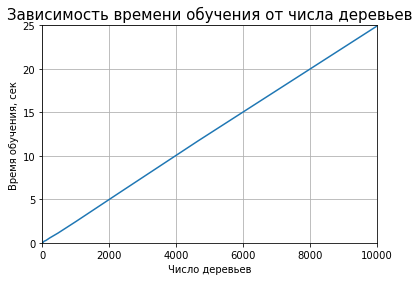

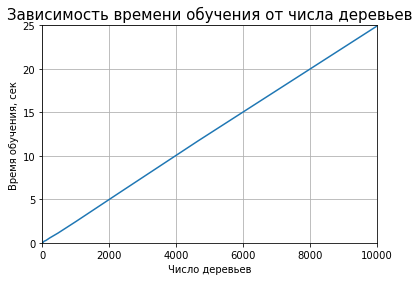

In [35]:
plt.title('Зависимость времени обучения от числа деревьев', fontsize = 15)

plt.plot(n_list, time_list)

plt.grid(True)

plt.ylabel('Время обучения, сек')
plt.xlabel('Число деревьев')

plt.xlim([0, 10000])
plt.ylim([0, 25])

plt.show()

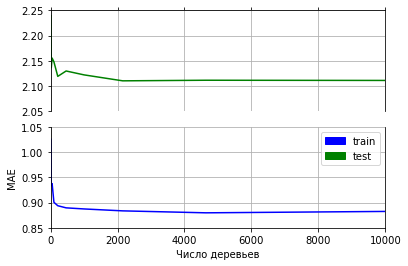

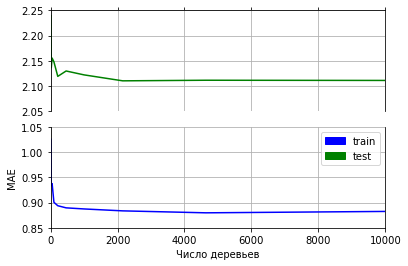

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.15)

ax1.grid(True)
ax2.grid(True)

plt.ylabel('MAE')
plt.xlabel('Число деревьев')

ax1.plot(n_list, MAE_test, color = 'green')
ax2.plot(n_list, MAE_train, color = 'blue')

ax1.set_ylim(2.05, 2.25)
ax2.set_ylim(0.85, 1.05)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

ax1.plot(transform=ax1.transAxes, linestyle="none")
ax2.plot(transform=ax2.transAxes, linestyle="none")

plt.xlim([0, 10000])

colors = {'train':'blue', 'test':'green'}        
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

**Ваши выводы**: Время практически линейно зависит от числа деревьев, чем больше деревьев - тем больше времени необходимо.
На тестовой выборке ошибка сначала резко падает при увеличении числа деревьев, а потом (при количестве деревьев более 2000) не уменьшается, сколько бы деревьев не добавляли.

Как мы с вами знаем, случайный лес постепенно улучшает качество предсказаний, увеличивая число деревьев в ансамбле. А что если мы обучили лес, но хотим `нарастить` его, добавив несколько деревьев? Или даже если к нам пришли новые данные и мы хотим добавить деревьев, обученных на них, но не удалять деревья, построенные на предыдущих данных? Такой трюк возможен, и для этого следует использовать warm_start. То, как правильно использовать warm_start можно глянуть [тут](https://stackoverflow.com/questions/42757892/how-to-use-warm-start/42763502)

### Задание 3.2 (кросс-проверка, 5 баллов)
**Данные**: датасет со стоимостью недвижимости в Бостоне   
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Создайте случайный лес со следующими параметрами: n_estimators = 1000, warm_start = True, random_state=42
2. Обучите полученный лес, засекая время, потраченное на обучение, и измерив качество предсказания на тесте по MAE
3. Увеличьте число деревьев в лесу. Для этого увеличьте число n_estimators на 1000.
4. Воспользуйтесь методом fit, чтобы дообучить новые деревья. Не забудьте замерить время и качество!
5. Повторяйте два предыдущих шага до тех пор, пока вы не оцените лес с 10000 деревьями.
6. Постройте графики качества и времени от количества деревьев (время считайте отдельно для каждого дообучения, без учета затрат на предыдущие итерации)
7. Проанализируйте результаты и графики, сделайте выводы про время обучения и качество, сравните с результатом из предыдущего пункта

In [37]:
MAE = []
time_list = []

regressor = RandomForestRegressor(n_estimators = 1000, warm_start = True, random_state = 42)

for n in range(1000, 10001, 1000):
    
    regressor.n_estimators = n

    time_start = time.time() 
    model = regressor.fit(X_train, y_train)
    time_list += [time.time() - time_start]
    
    y_pred = model.predict(X_test)
    MAE += [mean_absolute_error(y_pred, y_test)]

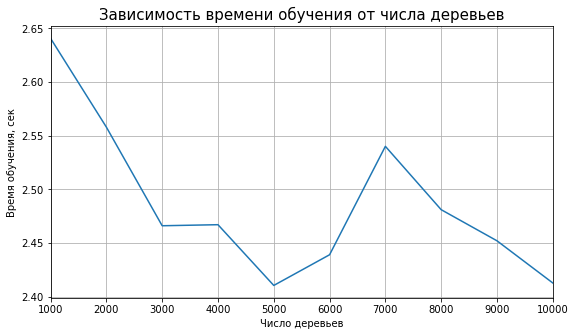

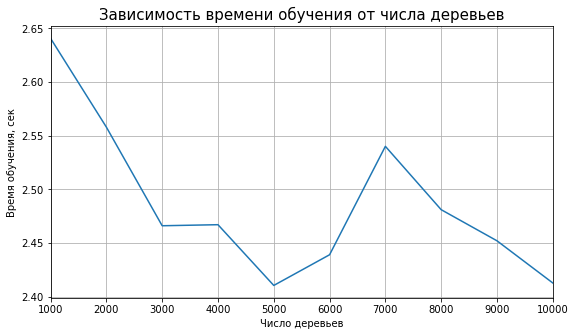

In [38]:
plt.figure(figsize=(9,5)) 
plt.title('Зависимость времени обучения от числа деревьев', fontsize = 15)

plt.plot(range(1000, 10001, 1000), time_list)

plt.grid(True)

plt.ylabel('Время обучения, сек')
plt.xlabel('Число деревьев')

plt.xlim([1000, 10000])

plt.show()

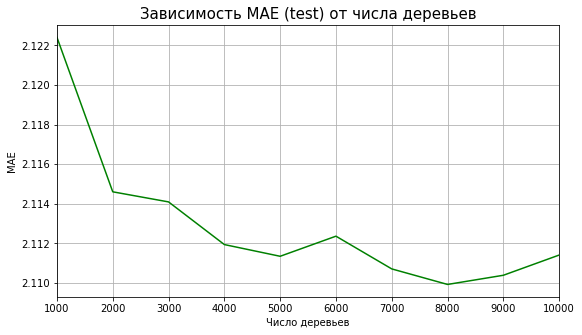

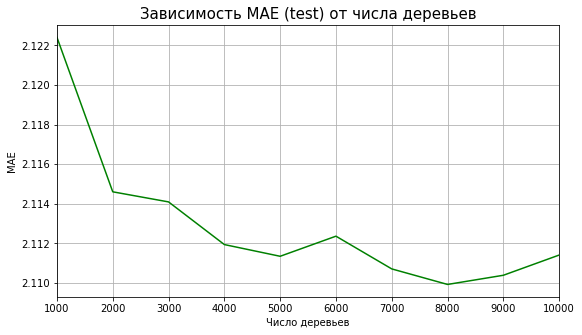

In [39]:
plt.figure(figsize=(9,5)) 
plt.title('Зависимость MAE (test) от числа деревьев', fontsize = 15)

plt.plot(range(1000, 10001, 1000), MAE, color = 'green')

plt.grid(True)

plt.ylabel('MAE')
plt.xlabel('Число деревьев')

plt.xlim([1000, 10000])

plt.show()

**Ваши выводы**: Времени требуется значительно меньше, если мы дообучаем некоторое количество деревьев, используя уже обученные, чем если будем учить всё с нуля. Времени требуется примерно одинаково на каждую тысячу (от 2.4 до 3.0 секунд), с увеличением числа деревьев ошибка на тестовой выборке уменьшается, принимая примерно такие же значения, как и при обучении всех деревьев сразу.
Таким образом, мы получаем преимущество во времени, но качество не улучшается.

## Важность признаков

**Внимание!** Для выполнения этого задания вам понадобится публичный датасет из задания `Деревья решений (ML)` на cv-gml.ru. Пожалуйста, выполните эти пункты:

1. Скачайте архив `Публичные тесты` задания `Деревья решений (ML)` и разархивируйте его в любом удобном для вас месте.
2. Найдите переменную `path_to_dataset`, расположенную на первой строке следующей ячейки, и измените её значение на полный путь до папки `[ПАПКА_ИЗВЛЕЧЕНИЯ]/public_tests/01_test_potentials_input/train/potentials`

С этого момента мы изменим датасет и попытаемся поиграться с физикой: возьмем коллекцию различных потенциалов и для них будем предсказывать некоторую физическую величину. Обученные физики говорят, что эта величина зависит от формы и глубины потенциала, а значит и мы можем тут чему-то научиться. Ранее эту задачу пытались решить с помощью сверточных нейронных сетей. А получится ли это у нас с помощью деревьев?

Загрузим датасет и посмотрим как он выглядит:



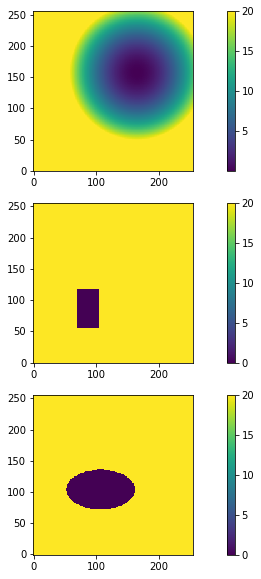

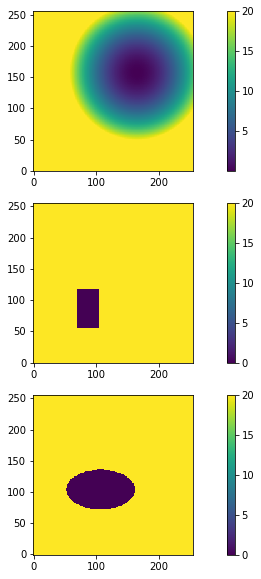

In [40]:
path_to_dataset = "C:/Users/User/Desktop/ML/trees/ML/public_tests/01_test_potentials_input/train/potentials"

chosen_ones = {'b2399918793e4228a3ea0a0a89adf11b.npz', '513d5523d14c47feb8b544138071c496.npz', 'ca9f96c404b740e3b28f583f9d9afbf8.npz'}

plt.figure(figsize=(12, 10))

def get_potential_dataset():

    global path_to_dataset

    """Return the training and testing splits of the potential dataset"""
    X, y = [], []

    plot_index = 1

    if not path_to_dataset.endswith("/"):
        path_to_dataset += "/"

    for f in os.listdir(path_to_dataset):

        npz = np.load(f'{path_to_dataset}{f}')
        data, target = npz['data'], npz['target']

        X.append(data)
        y.append(target)

        if f in chosen_ones:
            plt.subplot(len(chosen_ones), 1, plot_index)
            plt.imshow(data, origin="lower", interpolation='none')
            plt.colorbar()
            plot_index += 1
    plt.show()
    return train_test_split(np.array(X), np.array(y), random_state=42)

X_train, X_test, y_train, y_test = get_potential_dataset()



In [49]:
type(X_train[0])

numpy.ndarray

numpy.ndarray

Можно увидеть, что у нас имеется три типа потенциалов: два с бесконечно крутыми стенками, квадратный и эллиптический (их значение резко меняется на 0) и гармонический (красивый круглый, он плавно спускается к своему минимуму). В местах, где потенциала нет, значение матрицы равно 20.

Видно одну проблему: картинки квадратные (каждое изображение `256 х 256`), а большинство методов машинного обучение работает с векторами-признаками, и нам придется с этим позже разобраться. И еще более крупная проблема: потенциалы находятся в "случайных" местах рисунка. Возможно, позже нам придется с этим разобраться. Но вернёмся к нашим баранам. У линейных регрессоров есть одно очень полезное свойство: после обучения мы ``из коробки`` получаем важность признаков: чем выше коэффициент (или абсолютное его значение), стоящий у соответствующего признака, тем он важнее. Деревья решений не обладают столь же ``естественной`` оценкой важности признаков, однако мы всё равно можем её оценить. Называется эта оценка критерием Джини: она вычисляет то, как начинают ``ошибаться`` предсказания регрессора, если исключить данный признак. Чем сильнее ошибка, тем важнее признак. К нашей радости, sklearn так же ``из коробки`` включает данные оценки признаков. Давайте попробуем воспользоваться этой функцией и посмотреть на важность признаков.

### Задание 4.1 (кросс-проверка, 5 баллов)
**Данные**: потенциалы  
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Воспользоваться классом PotentialTransformer для преобразования двумерной матрицы в одномерный вектор
2. Воспользоваться классом Pipeline, чтобы "объединить" трансформатор и обучаемый метод
3. Обучить LinearSVR из sklearn на этом датасете.
4. Обучить RandomForestRegressor из sklearn на этом датасете.
5. Извлеките важность признаков из обученного леса с помощью `feature_importances_`. Извлеките также коэффициенты svm через coef_ (брать абсолютные значения необязательно).
6. Преобразуйте одномерный вектор важностей признаков в двумерную картинку таким образом, чтобы их можно было сравнивать с исходными потенциалами. Постройте рисунки важностей признаков с помощью plt.imshow. Добавьте легенду.
7. Оцените качество предсказаний через метод .predict.
8. Проанализируйте результаты. Можно ли сказать что у обоих методов получились одинаковые важности признаков? Можно ли сказать, что важность признаков отображает структуру потенциалов?

In [41]:
class PotentialTransformer:
    """
    A potential transformer.

    This class is used to convert the potential's 2d matrix to 1d vector of features.
    """

    def fit(self, x, y):
        """
        Build the transformer on the training set.
        :param x: list of potential's 2d matrices
        :param y: target values (can be ignored)
        :return: trained transformer
        """
        return self

    def fit_transform(self, x, y):
        """
        Build the transformer on the training set and return the transformed dataset (1d vectors).
        :param x: list of potential's 2d matrices
        :param y: target values (can be ignored)
        :return: transformed potentials (list of 1d vectors)
        """
        return self.transform(x)

    def transform(self, x):
        """
        Transform the list of potential's 2d matrices with the trained transformer.
        :param x: list of potential's 2d matrices
        :return: transformed potentials (list of 1d vectors)
        """
        return x.reshape((x.shape[0], -1))

C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


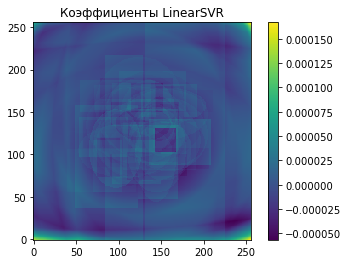

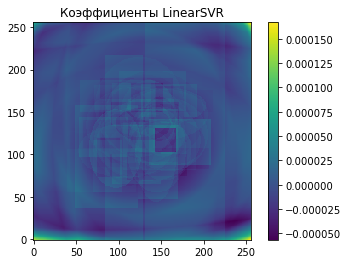

In [42]:
pipeline_SVR = Pipeline([
    ('transformer', PotentialTransformer()),
    ('method', LinearSVR())
])


model_SVR = pipeline_SVR.fit(X_train, y_train)
y_pred_SVR = model_SVR.predict(X_test)
coef = model_SVR.steps[1][1].coef_.reshape((256, 256))
plt.title('Коэффициенты LinearSVR')
plt.imshow(coef, origin="lower", interpolation='none')
plt.colorbar()

In [43]:
print('MAE LinearSVR:', mean_absolute_error(y_pred_SVR, y_test))

MAE LinearSVR: 0.0663934804259704
MAE LinearSVR: 0.0663934804259704


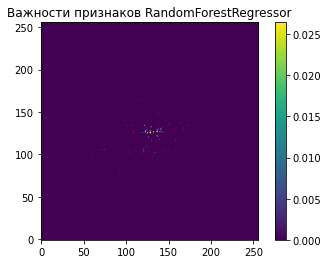

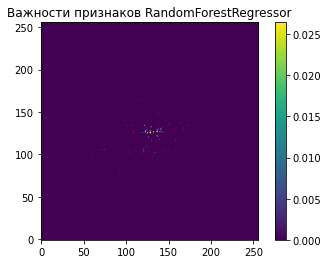

In [44]:
pipeline_RFR = Pipeline([
    ('transformer', PotentialTransformer()),
    ('method', RandomForestRegressor())
])

model_RFR = pipeline_RFR.fit(X_train, y_train)
y_pred_RFR = model_RFR.predict(X_test)
imp = model_RFR.steps[1][1].feature_importances_.reshape((256, 256))
plt.title('Важности признаков RandomForestRegressor')
plt.imshow(imp, origin="lower", interpolation='none')
plt.colorbar()

In [45]:
print('MAE RandomForestRegressor:', mean_absolute_error(y_pred_RFR, y_test))

MAE RandomForestRegressor: 0.0354179653392774
MAE RandomForestRegressor: 0.0354179653392774


**Ваши выводы**: У методов получиись разные важности признаков:  
RandomForestRegressor занулил большинство из них, при этом наибольшая важность у небольшого количества признаков в центре картинки,  
LinearSVR наоборот не занулил практически никакие признаки и наибольшие значения у признаков в углах.  
Ошибка RandomForestRegressor почти в два раза меньше, чем ошибка LinearSVR.

Если всё сделано верно, то в предыдущем задании вы должны были увидеть некоторый сумбур в коэффициентах svm. Можно увидеть, как некоторые потенциалы "отпечатались" в признаках, т.е. метод явно запомнил ответ, не пытаясь их обобщить. Видимо, нужно каким-то образом "стандартизировать" потенциалы, чтобы было легче "обобщать" их. К примеру, можно попробовать параллельно передвигать потенциал таким образом, чтобы в центре всегда оказывалось минимальное значение (места на матрице, не заполненные потенциалами, заполняются 20). Возможно вы заметите и другие "проблемы" или найдёте более элегантные решения, которые смогут помочь Вам улучшить результат.

**Внимание!** В этом задании разрешено пользоваться лишь методами, основанными на деревьях решений и их ансамблях (лесах). Пользоваться бустингом лесов нельзя (про них будет отдельное домашнее задание). Со списком лесов, которые реализованы в пакете sklearn.ensemble, можно ознакомиться [тут](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble). По описанию метода убедитесь, что бустинг в нём не применяется.

В задании на cv-gml.ru установлено ограничение по времени обучения в 10 минут. Поэтому, если вы будете перебирать параметры по сетке, то такой перебор может вполне занять несколько часов. Однако учтите, что время обучения леса зависит от способности леса построить оптимальное разбиение! Если ваше обучение проходит непозволительно долго, то, вероятно, лесам не удаётся подобрать хорошее оптимальное разбиение, а значит вам нужно подумать об ином трансформаторе.

**Внимание! Следующее задание проверяться на кросс-проверке НЕ БУДЕТ! Это решение нужно будет загрузить в проверяющую систему в задание `Деревья решений (ML)`** Здесь вы можете просто поиграть с данными и решением, подобрать оптимальные параметры на кросс-валидации

### Задание 4.2 (ML-задание, 15 баллов)
**Данные**: потенциалы  
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Улучшить метод PotentialTransformer, чтобы "стандартизировать" данные (к примеру, переносить потенциалы в одно и то же место)
2. Воспользоваться классом Pipeline, чтобы "объединить" трансформатор и обучаемый метод
3. Обучить лучшие деревья на диком западе (можно воспользоваться любой реализацией лесов из sklearn).
4. Отобразить важность признаков получившегося дерева/леса
5. Загрузить решение в тестирующую систему

In [233]:
class PotentialTransformer:

    def fit(self, x, y):
        return self

    def fit_transform(self, x, y):
        return self.transform(x)

    def transform(self, x):
        x_new = []
        for obj in x:
            
            n = len(obj)
            m = len(obj[0])

            max_col = -1
            max_row = -1
            min_col = m + 1
            min_row = n + 1
            
            max_col_zero = -1
            max_row_zero = -1
            min_col_zero = m + 1
            min_row_zero = n + 1
            
            for row in range(n):
                for col in range(m):
                    
                    if obj[row][col] < 20:

                        if min_col > col:
                            min_col = col

                        if min_row > row:
                            min_row = row

                        if max_col < col:
                            max_col = col

                        if max_row < row:
                            max_row = row
                            
                    if obj[row][col] < 0.05:

                        if min_col_zero > col:
                            min_col_zero = col

                        if min_row_zero > row:
                            min_row_zero = row

                        if max_col_zero < col:
                            max_col_zero = col

                        if max_row_zero < row:
                            max_row_zero = row
            
            h_zero = max_row_zero - min_row_zero + 1
            w_zero = max_col_zero - min_col_zero + 1
            new_obj = np.full((n, m), 20.)

            min_col_1_zero = (m - w_zero)//2
            min_row_1_zero = (n - h_zero)//2
            max_col_1_zero = min_col_1_zero + w_zero
            max_row_1_zero = min_row_1_zero + h_zero
            
            for i in range(min_row, max_row + 1):
                for j in range(min_col, max_col + 1):
                    if (min_row_1_zero - min_row_zero + i < n) and (min_col_1_zero - min_col_zero + j < m)\
                    and (min_row_1_zero - min_row_zero + i >= 0) and (min_col_1_zero - min_col_zero + j >= 0): 
                        new_obj[min_row_1_zero - min_row_zero + i][min_col_1_zero - min_col_zero + j] = obj[i][j]
        
            max_col = -1
            max_row = -1
            min_col = m + 1
            min_row = n + 1
            
            for row in range(n):
                for col in range(m):
                    
                    if new_obj[row][col] < 20:

                        if min_col > col:
                            min_col = col

                        if min_row > row:
                            min_row = row

                        if max_col < col:
                            max_col = col

                        if max_row < row:
                            max_row = row
                            
            if min_row < (n - max_row):
                for row in range(n - max_row, n - min_row):
                    new_obj[row] = new_obj[n - 1 - row]
                    
            if min_row > (n - max_row):
                for row in range(n - max_row, min_row):
                    new_obj[row] = new_obj[n - 1 - row]
                    
            new_obj = new_obj.T
            
            if min_col < (m - max_col):
                for col in range(m - max_col, m - min_col):
                    new_obj[col] = new_obj[m - 1 - col]
                    
            if min_col > (n - max_col):
                for col in range(m - max_col, min_col):
                    new_obj[col] = new_obj[m - 1 - col]
                    
            new_obj = new_obj.T
            
            x_new += [new_obj]         
        return x_new

In [170]:
a = np.full((2, 3), 20.)
len(a)
len(a[0])

3

42986

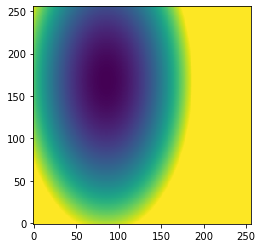

In [254]:
obj = X_train[0]
obj
plt.imshow(obj, origin="lower", interpolation='none')
len(obj[obj < 20])

In [205]:
len(obj[obj < 0.05])

142

46934


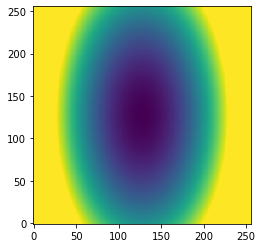

In [255]:
tr = PotentialTransformer()
new_obj = tr.transform([obj, X_train[7], X_train[5]])[0]
plt.imshow(new_obj, origin="lower", interpolation='none')
print(len(new_obj[new_obj < 20]))

In [183]:
new_obj

array([[20., 20., 20., ..., 20., 20., 20.],
       [20., 20., 20., ..., 20., 20., 20.],
       [20., 20., 20., ..., 20., 20., 20.],
       ...,
       [20., 20., 20., ..., 20., 20., 20.],
       [20., 20., 20., ..., 20., 20., 20.],
       [20., 20., 20., ..., 20., 20., 20.]])

In [175]:
ans = []
    for idx in range(x.shape[0]):
        # print(idx)
        a = x[idx]
        p = []
        ar = []
        margin = 0
        for i in range(0, 256):
            if np.any(a.T[i] != 20.0):
                p.append(i)
                ar.append(a.T[i])
        p1 = np.array(p) - ((p[0] + p[-1]) // 2 - 127)
        if len(ar[0][ar[0] != 20.0]) > len(ar[-1][ar[-1] != 20.0]):
            for i in p:
                if len(a.T[i][a.T[i] != 20.0]) < len(ar[0][ar[0] != 20.0]):
                    margin = p[-1] - i
                    break
            if (p1[-1] + margin) > 255:
                margin = 255 - p1[-1]
        elif len(ar[0][ar[0] != 20.0]) < len(ar[-1][ar[-1] != 20.0]):
            for i in p[::-1]:
                if len(a.T[i][a.T[i] != 20.0]) < len(ar[-1][ar[-1] != 20.0]):
                    margin = p[0] - i
                    break
            if (p1[0] + margin) < 0:
                margin = -p1[0]

        p1 = p1 + margin
        b = np.zeros((256, 256)) + 20
        b.T[p1] = ar
        p = []
        ar = []
        margin = 0
        for i in range(0, 256):
            if np.any(b[i] != 20.0):
                p.append(i)
                ar.append(b[i])
        p1 = np.array(p) - ((p[0] + p[-1]) // 2 - 127)
        if len(ar[0][ar[0] != 20.0]) > len(ar[-1][ar[-1] != 20.0]):
            for i in p:
                if len(b[i][b[i] != 20.0]) < len(ar[0][ar[0] != 20.0]):
                    margin = p[-1] - i
                    break
            if (p1[-1] + margin) > 255:
                margin = 255 - p1[-1]
        elif len(ar[0][ar[0] != 20.0]) < len(ar[-1][ar[-1] != 20.0]):
            for i in p[::-1]:
                if len(b[i][b[i] != 20.0]) < len(ar[-1][ar[-1] != 20.0]):
                    margin = p[0] - i
                    break
            if (p1[0] + margin) < 0:
                margin = -p1[0]
        p1 = p1 + margin
        b = np.zeros((256, 256)) + 20
        b[p1] = ar

        ans.append(b)
    ans = np.array(ans)
    ans[ans == 20.0] = 10000

IndentationError: unexpected indent (Temp/ipykernel_28272/2055369979.py, line 2)

Ну что, детишки. Поздравляю с еще одним выполненным ДЗ!

